In [1]:
import csv
import os

In [2]:
# find handful of short lines, prove that each sequence contains at least 2 kmers
# (database contains exactly 408307 sequences, last output line is supposed to be blank)
total_seqs = 408307
fn = './results/s2k-8-600000.csv'
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        if len(line) < 10: print(i, line, end='')
        if i == total_seqs: break

117943 0,23
176265 15,44,45
188842 8,47,86
244047 0,65
359658 7,78
397402 38,39,40
408106 0,65,66
408307 


In [3]:
# find kmer containment frequencies
from collections import Counter

c = Counter()
fn = './results/s2k-8-600000.csv'
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        count = len(line.split(','))
        c[count] += 1
        if len(line) < 10: print(i, line[:-1], count)
        if i == 408306: break

c.most_common(5)

117943 0,23 2
176265 15,44,45 3
188842 8,47,86 3
244047 0,65 2
359658 7,78 2
397402 38,39,40 3
408106 0,65,66 3


[(94, 25293), (69, 18312), (70, 18095), (82, 15763), (75, 14761)]

In [4]:
s = 0
for i in range(20):
    s += c[i]
s

286

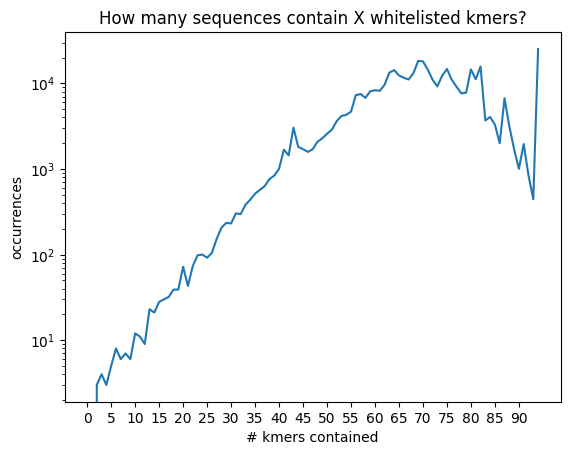

In [5]:
# plot
import matplotlib.pyplot as plt
import seaborn as sns

c_items = sorted(c.items(), key=lambda x: x[0])
ys = [0] * (c_items[-1][0] + 1)
for ci in c_items:
    ys[ci[0]] = ci[1]

sns.lineplot(ys)
plt.title('How many sequences contain X whitelisted kmers?')
plt.yscale('log')
plt.ylabel('occurrences')
plt.xlabel('# kmers contained')
plt.xticks(list(range(95)[::5]))
plt.show()

In [6]:
# get most frequent kmers
fn = './results/k-8-600000.csv'
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        freq = int(line.split(';')[1]) / total_seqs
        if freq > 0.96: print(i, '{:.4f}'.format(freq))

3 0.9619
9 0.9647
10 0.9710
26 0.9640
37 0.9674
38 0.9658
41 0.9602
44 0.9619
45 0.9614
46 0.9616
47 0.9712


In [7]:
# find all sequences containing 47 and all that don't; this part is slow so pick seed manually
fn = './results/s2k-8-600000.csv'
kmi = '47'
contain = []
nocontain = []
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        if kmi in line: contain.append((i, line[:-1]))
        else: nocontain.append((i, line[:-1]))

        if i == total_seqs - 1: break

len(nocontain)

11742

In [8]:
# greedy search to try to find minimum spanning kmers
spanning_kmers = [kmi]
nc = nocontain
while len(nc) != 0:
    count = Counter()
    for e in nc:
        for i in e[1].split(','):
            count[i] += 1
    best = count.most_common(1)[0][0]

    nc_next = []
    for e in nc:
        if best not in e[1].split(','):
            nc_next.append(e)
    nc = nc_next

    print(best, len(nc))
    spanning_kmers.append(best)

print(len(spanning_kmers), 'spanning kmers:', spanning_kmers)

10 929
68 292
38 103
25 49
0 30
15 19
62 13
76 8
4 5
18 3
12 1
7 0
13 spanning kmers: ['47', '10', '68', '38', '25', '0', '15', '62', '76', '4', '18', '12', '7']


In [9]:
# print actual kmers in order
fn = './results/k-8-600000.csv'
kms = []
with open(fn, 'r') as f:
    for line in f:
        kms.append(line.split(';')[0])
        
for ki in spanning_kmers:
    print(ki, '\t', kms[int(ki)])

47 	 (('A', 0), ('A', 1), ('A', 5), ('U', 6), ('G', 8), ('C', 10), ('G', 11), ('G', 12))
10 	 (('G', 0), ('C', 2), ('A', 3), ('G', 4), ('C', 5), ('G', 10), ('C', 11), ('G', 13))
68 	 (('A', 0), ('G', 18), ('G', 19), ('A', 20), ('U', 22), ('G', 28), ('U', 29), ('A', 30))
38 	 (('A', 0), ('U', 2), ('A', 3), ('C', 10), ('A', 11), ('A', 12), ('A', 19), ('A', 20))
25 	 (('A', 0), ('U', 1), ('A', 3), ('G', 4), ('A', 5), ('C', 8), ('U', 14), ('A', 15))
0 	 (('A', 0), ('U', 41), ('A', 62), ('G', 64), ('G', 65), ('C', 73), ('A', 74), ('G', 75))
15 	 (('G', 0), ('C', 1), ('G', 3), ('A', 5), ('A', 6), ('C', 9), ('U', 38), ('G', 39))
62 	 (('G', 0), ('U', 2), ('G', 3), ('C', 4), ('A', 5), ('G', 7), ('G', 8), ('U', 23))
76 	 (('G', 0), ('G', 6), ('C', 9), ('U', 18), ('G', 19), ('A', 21), ('C', 22), ('C', 24))
4 	 (('G', 0), ('C', 8), ('A', 9), ('G', 10), ('G', 15), ('A', 17), ('U', 21), ('A', 42))
18 	 (('A', 0), ('A', 9), ('A', 20), ('G', 30), ('G', 32), ('C', 37), ('A', 86), ('A', 92))
12 	 (('A'

In [10]:
# expand to keep minimum 2 kmers per sequence property
spanning_kmers_2 = ['47', '10']

fn = './results/s2k-8-600000.csv'
nc = []
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        if spanning_kmers_2[0] not in line or spanning_kmers_2[1] not in line:
            nc.append((i, line[:-1]))

        if i == total_seqs - 1: break

# make sets for fast membership queries
nc = [(x,{int(z) for z in y.split(',')}) for x,y in nc]

print(len(nc))

in_order = [int(x) for x in spanning_kmers_2]
spanning_kmers_2 = set(in_order)

while len(nc) != 0:
    count = Counter()
    for e in nc:
        for i in e[1]:
            count[i] += 1
    best = count.most_common()

    for i in range(len(best)):
        if best[i][0] not in spanning_kmers_2:
            spanning_kmers_2.add(best[i][0])
            new = best[i][0]
            break

    nc_next = []
    for e in nc:
        inter = len(spanning_kmers_2.intersection(e[1]))
        if inter < 2:
            nc_next.append(e)
    nc = nc_next

    print(new, len(nc))
    in_order.append(new)

print(len(spanning_kmers_2), 'spanning kmers:', in_order)

22648
26 3318
65 898
3 374
38 230
62 145
78 95
17 67
7 53
44 41
12 34
67 26
15 20
0 16
64 12
8 8
35 5
6 4
41 4
42 3
23 2
40 1
70 0
24 spanning kmers: [47, 10, 26, 65, 3, 38, 62, 78, 17, 7, 44, 12, 67, 15, 0, 64, 8, 35, 6, 41, 42, 23, 40, 70]


[(13, 238465), (12, 86174), (11, 39335), (10, 16967), (9, 13584)]


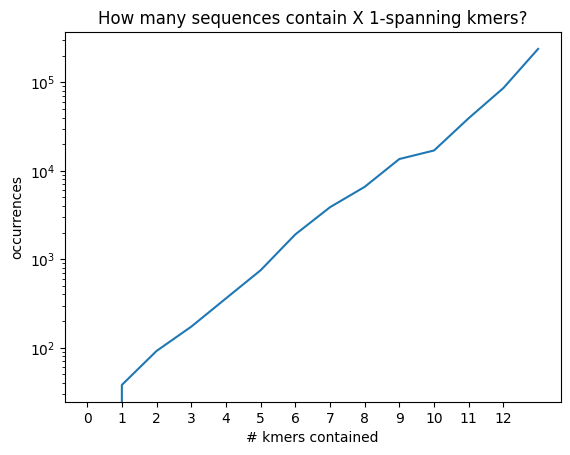

In [23]:
# how many seqs contain X 1-spanning kmers?
sk = set(spanning_kmers)

c = Counter()
fn = './results/s2k-8-600000.csv'
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        count = 0
        for k in line[:-1].split(','):
            if k in sk: count += 1
        c[count]  += 1
        if i == 408306: break

print(c.most_common(5))

c_items = sorted(c.items(), key=lambda x: x[0])
ys = [0] * (c_items[-1][0] + 1)
for ci in c_items:
    ys[ci[0]] = ci[1]

sns.lineplot(ys)
plt.title('How many sequences contain X 1-spanning kmers?')
plt.yscale('log')
plt.ylabel('occurrences')
plt.xlabel('# kmers contained')
plt.xticks(list(range(len(spanning_kmers))))
plt.show()

[(24, 169675), (23, 102348), (22, 45086), (21, 24635), (20, 18954)]


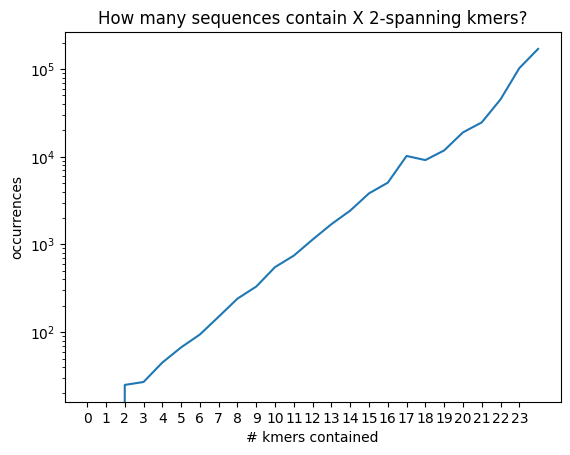

In [30]:
# how many contain X 2-spanning kmers?
sk = set(str(x) for x in in_order)

c = Counter()
fn = './results/s2k-8-600000.csv'
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        count = 0
        for k in line[:-1].split(','):
            if k in sk: count += 1
        c[count]  += 1
        if i == 408306: break

print(c.most_common(5))

c_items = sorted(c.items(), key=lambda x: x[0])
ys = [0] * (c_items[-1][0] + 1)
for ci in c_items:
    ys[ci[0]] = ci[1]

sns.lineplot(ys)
plt.title('How many sequences contain X 2-spanning kmers?')
plt.yscale('log')
plt.ylabel('occurrences')
plt.xlabel('# kmers contained')
plt.xticks(list(range(len(spanning_kmers_2))))
plt.show()

In [26]:
print(spanning_kmers)

['47', '10', '68', '38', '25', '0', '15', '62', '76', '4', '18', '12', '7']
